Deep Learning - Final Exam

NIM : 2440016804

Nama : Rio Pramana

Kelas : LA01

# Nomor 1a, 1b, dan 1c

# Prepare & Preprocess Dataset

Sebelum melakukan pembuatan model dan training, saya lakukan beberapa preprocessing terhadap dataset yang ada terlebih dahulu

## Import libraries

In [1]:
from os import listdir
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from datetime import datetime 
import cv2
from keras import models, layers, regularizers
from keras import backend as K
from sklearn.model_selection import train_test_split

## Define path to folders

In [2]:
TRAIN_X_PATH = './Skin Cancer/Training_Data/'
TRAIN_Y_PATH = './Skin Cancer/Training_GroundTruth/'
TEST_X_PATH = './Skin Cancer/Test_Data/'
TEST_Y_PATH = './Skin Cancer/Test_GroundTruth/'

## Helper function to display images

Berikut ini adalah 2 function yang saya gunakan untuk membantu proses display images. `show_img_side_by_side` akan saya gunakan untuk menampilkan 2 images secara berdampingan

In [3]:
def show_img(img, is_gray = True):
    plt.figure(figsize=(10, 8))
    if is_gray == False:
        plt.imshow(img)
    else:
        plt.imshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
def show_img_side_by_side(img1, img2, is_gray = True):
    plt.figure(figsize=(10, 8))
    fig, ax = plt.subplots(1, 2)
    if is_gray == False:
        ax[0].imshow(img1)
        ax[1].imshow(img2)
    else:
        ax[0].imshow(img1, cmap='gray')
        ax[1].imshow(img2, cmap='gray')
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    plt.show()    

## Function to preprocess dataset

Function di bawah ini digunakan untuk mengambil data image beserta ground truth dari setiap dataset. Untuk original imagesnya, dibaca menggunakan cv2.imread() dengan flag = 1. Sedangkan untuk mask/ground truthnya, dibaca dengan flag = 0 untuk mendapatkan grayscale imagenya

Setiap image/mask yang diambil akan di-resize menjadi resized_dim (yang saya set menjadi 128) untuk menyederhanakan proses komputasi yang akan dilakukan serta mempermudah proses training karena semua inputnya akan memiliki dimensi yang sama. `interpolation = cv2.INTER_LANCZOS4` merupakan salah satu interpolation yang terbaik untuk downscaling image. Images yang ada akan di down-scale karena semua images yang ada memiliki dimensi 1022 x 767

Setelah itu, original images akan dinormalisasi dan mask/ground truth akan direscale menjadi skala 0 - 1

In [4]:
def get_preprocessed_dataset(IMG_PATH, MASK_PATH, resized_dim, is_train = True):
    #ambil semua nama file imagesnya
    img_file_names = listdir(IMG_PATH)
    mask_file_names = listdir(MASK_PATH)
    #lists yang akan di-return
    img_dataset = [] #image asli
    mask_dataset = [] #mask hasil segmentation (ground truth)
    
    for file_name in img_file_names:
        img = cv2.imread(IMG_PATH + file_name, 1) #baca image
        img = cv2.resize(img, dsize = (resized_dim,resized_dim), interpolation = cv2.INTER_LANCZOS4) #resize image
        img_dataset.append(img)
        
    #jika mask, baca image secara grayscale:
    for file_name in mask_file_names:
        img = cv2.imread(MASK_PATH + file_name, 0) #baca image
        img = cv2.resize(img, dsize = (resized_dim,resized_dim), interpolation = cv2.INTER_LANCZOS4) #resize image
        mask_dataset.append(img)
    
    #Normalize img_dataset (mask_dataset tidak di normalize)
    img_dataset = np.array(img_dataset) / 255.
    #Rescaling mask_dataset menjadi scale 0 - 1
    mask_dataset = np.expand_dims((np.array(mask_dataset)), 3) / 255.
    
    return img_dataset, mask_dataset

## Get preprocessed dataset

In [5]:
train_x, train_y = get_preprocessed_dataset(TRAIN_X_PATH, TRAIN_Y_PATH, 128)
test_x, test_y = get_preprocessed_dataset(TEST_X_PATH, TEST_Y_PATH, 128, is_train = False)

Dibawah ini ditampilkan 1 image & mask dari masing-masing dataset

<Figure size 720x576 with 0 Axes>

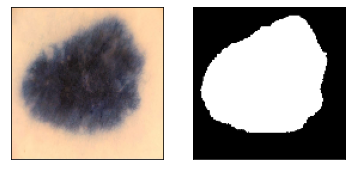

<Figure size 720x576 with 0 Axes>

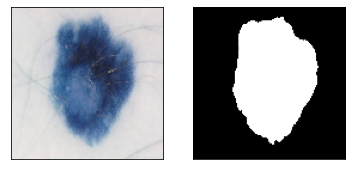

In [6]:
show_img_side_by_side(train_x[0], train_y[0])
show_img_side_by_side(test_x[0], test_y[0])

In [7]:
print(train_x[0].shape, train_y[0].shape)
print(test_x[0].shape, test_y[0].shape)

(128, 128, 3) (128, 128, 1)
(128, 128, 3) (128, 128, 1)


## Split train dataset untuk menghasilkan validation dataset

In [8]:
num_train_data = train_x.shape[0]
num_test_data = test_x.shape[0]
total_data = num_train_data + num_test_data
print("Number of training data: {}".format(num_train_data))
print("Number of test data: {}".format(num_test_data))
print("Total number of data: {}".format(total_data))
print("Current ratio: Training ({}%), Test({}%)".format(round(num_train_data/total_data*100), round(num_test_data/total_data*100)))

Number of training data: 900
Number of test data: 379
Total number of data: 1279
Current ratio: Training (70%), Test(30%)


Pada dataset yang diberikan, belum ada validation dataset. Oleh karena itu, saya memutuskan untuk membagi train dataset menjadi 85% train dataset dan 15% validation dataset agar test dataset yang disediakan tidak berubah

In [9]:
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, test_size = 0.15, random_state = 0)

In [10]:
num_train_data = X_train.shape[0]
num_val_data = X_val.shape[0]
num_test_data = test_x.shape[0]
total_data = num_train_data + num_test_data + num_val_data
print("Number of training data: {}".format(num_train_data))
print("Number of validation data: {}".format(num_val_data))
print("Number of test data: {}".format(num_test_data))
print("Total number of data: {}".format(total_data))
print("Current ratio: Training ({}%), Validation ({}%), Test({}%)".format(
        round(num_train_data/total_data*100),
        round(num_val_data/total_data*100),
        round(num_test_data/total_data*100)
    )
)      

Number of training data: 765
Number of validation data: 135
Number of test data: 379
Total number of data: 1279
Current ratio: Training (60%), Validation (11%), Test(30%)


# 1a. Buat arsitektur tanpa Soft-Attention

Saya membuat arsitektur tanpa soft-attention (yang saya beri nama `modelWithoutAttention`) dengan mengikuti arsitektur UNet sebagai referensi. UNet merupakan sebuah arsitektur deep learning yang sering digunakan untuk task image segmentation, terutama untuk medical image.

Terdapat beberapa alasan mengapa UNet cocok digunakan untuk task ini:
1. Arsitektur UNet merupakan salah satu arsitektur deep learning yang termasuk ringan. UNet biasanya memiliki waktu komputasi/processing yang lumayan cepat jika dibandingkan dengan arsitektur deep learning lainnya
2. Struktur arsitektur UNet sangat cocok untuk image segmentation. UNet memiliki struktur encoder-decoder yang dapat melakukan pencarian dan lokalisasi objek yang ingin dicari pada sebuah image dengan baik. Bagian encoder akan berisi layers yang akan melakukan down-sampling pada input image, sedangkan bagian decoder akan berisi layers yang akan melakukan up-sampling dari hasil akhir bagian encoder agar kita bisa mendapatkan output image yang dimensinya sesuai dengan input awal
3. UNet dalam arsitekturnya memiliki skip connections antara encoder dan decoder yang digunakan untuk menyimpan informasi dan detail penting dari sebuah image (spatial information) di encoder yang akan ditransfer ke bagian decoder. Hal ini penting karena dalam task ini kita ingin tetap menyimpan data/informasi mengenai objek/detail yang ada pada image dengan tepat

Arsitektur UNet:
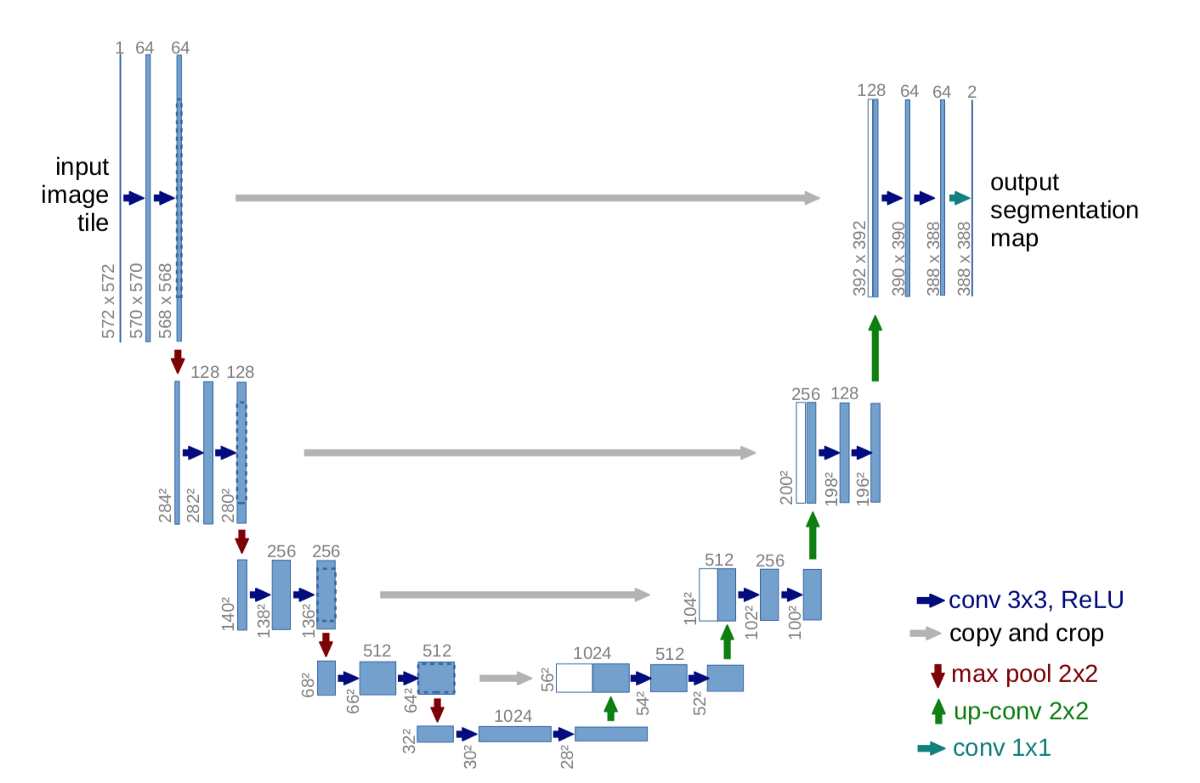

Dalam setiap step, biasanya terdapat 2 buah convolutional layer yang memiliki proses yang sama. Oleh karena itu, akan didefinisikan sebuah function bernama `conv_block` yang akan menggabungkan seluruh layer tersebut menjadi sebuah block yang merepresentasikan sebuah step

Pada kasus ini, untuk meringankan proses training, saya melakukan image resize menjadi 128x128 sehingga saya mengubah arsitektur UNet diatas dengan menghilangkan step pertamanya (langkah pertama langsung dimulai dari step kedua yang memiliki filter size 128x128)

In [11]:
def conv_block(x, filter_size, size, dropout):
    #layer pertama
    convolutional = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    convolutional = layers.BatchNormalization(axis=3)(convolutional) #batch normalization
    convolutional = layers.Activation("relu")(convolutional)
    #layer kedua
    convolutional = layers.Conv2D(size, (filter_size, filter_size), padding="same")(convolutional)
    convolutional = layers.BatchNormalization(axis=3)(convolutional) #batch normalization
    convolutional = layers.Activation("relu")(convolutional)
    #aplikasikan dropout
    if dropout > 0:
        convolutional = layers.Dropout(dropout)(convolutional) #dropout

    return convolutional

def repeat_elem(tensor, rep):
    #Untuk menduplikasi elements pada sebuah tensor
    #Jika axis = 3, rep = 3, dan shape tensor adalah (None,128,128,1), maka hasilnya adalah..
    #..tensor dengan shape (None,128,128,3)
     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3), arguments={'repnum': rep})(tensor)

## Definisikan model tanpa soft-attention

In [12]:
def modelWithoutAttention(input_shape, NUM_CLASSES, dropout_rate):
    num_filter = 128 # number of filters for the first layer
    size_filter = 3 # size of the convolutional filter
    size_upsample = (2, 2) # size of upsampling filters
    
    # input layer
    inputs = layers.Input(input_shape, dtype=tf.float32)

    # Layer-layer di bagian encoder
    # step1
    conv_64 = conv_block(inputs, size_filter, num_filter, dropout_rate)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # step2
    conv_32 = conv_block(pool_32, size_filter, 2*num_filter, dropout_rate)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # step3
    conv_16 = conv_block(pool_16, size_filter, 4*num_filter, dropout_rate)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # step4/base sehingga tidak ada max pooling lagi
    conv_8 = conv_block(pool_8, size_filter, 8*num_filter, dropout_rate)

    # layer-layer di bagian decoder
    # step1
    up_16 = layers.UpSampling2D(size=size_upsample, data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, conv_16], axis=3)
    up_conv_16 = conv_block(up_16, size_filter, 4*num_filter, dropout_rate)

    # step2
    up_32 = layers.UpSampling2D(size=size_upsample, data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, conv_32], axis=3)
    up_conv_32 = conv_block(up_32, size_filter, 2*num_filter, dropout_rate)

    # step3
    up_64 = layers.UpSampling2D(size=size_upsample, data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, conv_64], axis=3)
    up_conv_64 = conv_block(up_64, size_filter, num_filter, dropout_rate)
    
    # output layer
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_64)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)

    # Model 
    model = models.Model(inputs, conv_final, name="modelWithoutAttention")
    return model

## Helper functions for metrics

Untuk membantu evaluasi model selama proses training, saya membuat functions untuk mendapatkan jaccard coefficient dan IoU coefficient

In [13]:
def jaccard_coefficient(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    jaccard_coef = (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)
    return jaccard_coef

def IoU_coefficient(y_true, y_pred):
    T = K.flatten(y_true)
    P = K.flatten(y_pred)
    intersection = K.sum(T * P)
    IoU = (intersection + 1.0) / (K.sum(T) + K.sum(P) - intersection + 1.0)
    return IoU

def IoU_loss(y_true, y_pred):
    return -IoU_coefficient(y_true, y_pred)

Dropout probability memiliki value 0.3 yang dapat membantu mempercepat proses training model serta mengurangi kemungkinan terjadinya overfitting karena arsitektur model yang dimiliki cukup kompleks

In [14]:
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
num_classes = 1
dropout_p = 0.3

print(input_shape)

(128, 128, 3)


## Training modelWithoutAttention

In [15]:
from focal_loss import BinaryFocalLoss

learning_rate = 0.01
modelWithoutAttention = modelWithoutAttention(input_shape, num_classes, dropout_p)
modelWithoutAttention.compile(
    optimizer = Adam(learning_rate = learning_rate),
    loss = BinaryFocalLoss(gamma = 2),
    metrics = ['accuracy', jaccard_coefficient]
)

print(modelWithoutAttention.summary())

Model: "modelWithoutAttention"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 12  3584        ['input_1[0][0]']                
                                8)                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 12  512        ['conv2d[0][0]']                 
 alization)                     8)                                            

 dropout_3 (Dropout)            (None, 16, 16, 1024  0           ['activation_7[0][0]']           
                                )                                                                 
                                                                                                  
 up_sampling2d (UpSampling2D)   (None, 32, 32, 1024  0           ['dropout_3[0][0]']              
                                )                                                                 
                                                                                                  
 concatenate (Concatenate)      (None, 32, 32, 1536  0           ['up_sampling2d[0][0]',          
                                )                                 'dropout_2[0][0]']              
                                                                                                  
 conv2d_8 (Conv2D)              (None, 32, 32, 512)  7078400     ['concatenate[0][0]']            
          

None


In [18]:
epochs = 3
BATCH_SIZE = 16

start_time = datetime.now() 
no_att_history = modelWithoutAttention.fit(
    X_train, y_train, 
    verbose = 1,
    batch_size = BATCH_SIZE,
    validation_data = (X_val, y_val), 
    shuffle = False,
    epochs = epochs
)
stop_time = datetime.now()
execution_time_noatt = stop_time-start_time
print("No attention execution time is: ", execution_time_noatt)
modelWithoutAttention.save('no_attention.hdf5')

Epoch 1/3
48/48 [==============================] - 1670s 35s/step - loss: 0.1002 - accuracy: 0.8575 - jaccard_coefficient: 0.3168 - val_loss: 11.7679 - val_accuracy: 0.2627 - val_jaccard_coefficient: 0.2628
Epoch 2/3
48/48 [==============================] - 1815s 38s/step - loss: 0.0777 - accuracy: 0.8876 - jaccard_coefficient: 0.3462 - val_loss: 1.4350 - val_accuracy: 0.5347 - val_jaccard_coefficient: 0.3363
Epoch 3/3
48/48 [==============================] - 1918s 40s/step - loss: 0.0716 - accuracy: 0.8962 - jaccard_coefficient: 0.3631 - val_loss: 0.1379 - val_accuracy: 0.8567 - val_jaccard_coefficient: 0.3588
No attention execution time is:  1:30:03.972961


Setelah dilakukan training dengan 3 epochs, model ini meraih akurasi sebesar 89.62% dan validation accuracy sebesar 85.67% yang memakan waktu 1 jam 30 menit

# 1b. Tambahkan Soft-Attention pada arsitektur 1a

Attention pada UNet merupakan sebuah metode yang digunakan untuk berfokus pada activation yang diperlukan selama training sehingga penggunaan sumber daya komputasinya bisa digunakan dengan lebih efisien dan network yang dihasilkan dapat memiliki generalization yang lebih baik

Soft-attention sendiri bekerja dengan memberikan weight yang berbeda terhadap setiap bagian dari sebuah image. Bagian yang lebih relevan akan mendapatkan weight yang lebih besar. Selama training (bisa menggunakan backpropagation), weight-weight ini juga akan di-training sehingga model akan belajar untuk lebih berfokus pada bagian yang relevan tersebut (dalam hal ini bagian yang menunjukkan skin cancer)

Pada implementasi skip connections di UNet, terdapat proses kombinasi spatial information dari bagian encoder ke bagian decoder untuk menyimpan spatial information yang baik (yang dimiliki oleh bagian encoder). Namun, proses tersebut juga membawa feature representation yang lebih jelek (dari bagian encoder) sehingga hal ini perlu kita coba untuk eliminasi. Soft-attention diimplementasikan untuk mengurangi efek dari hal tersebut sehingga activation pada bagian-bagian image yang tidak relevan tidak akan memengaruhi model secara signifikan

Soft-attention akan diterapkan pada setiap skip connection pada model UNet ini seperti pada gambar berikut:
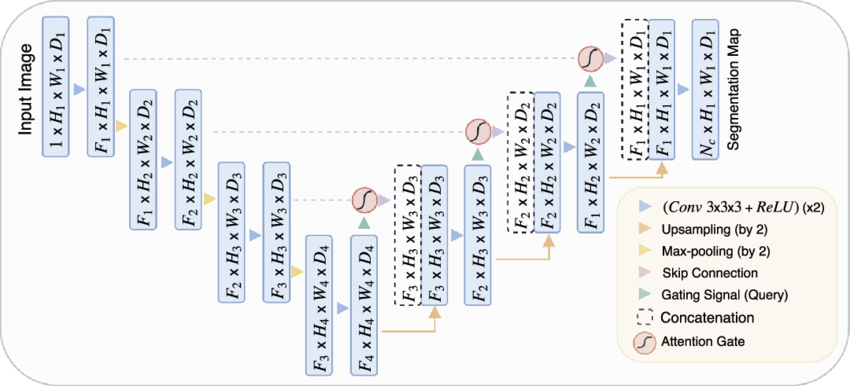

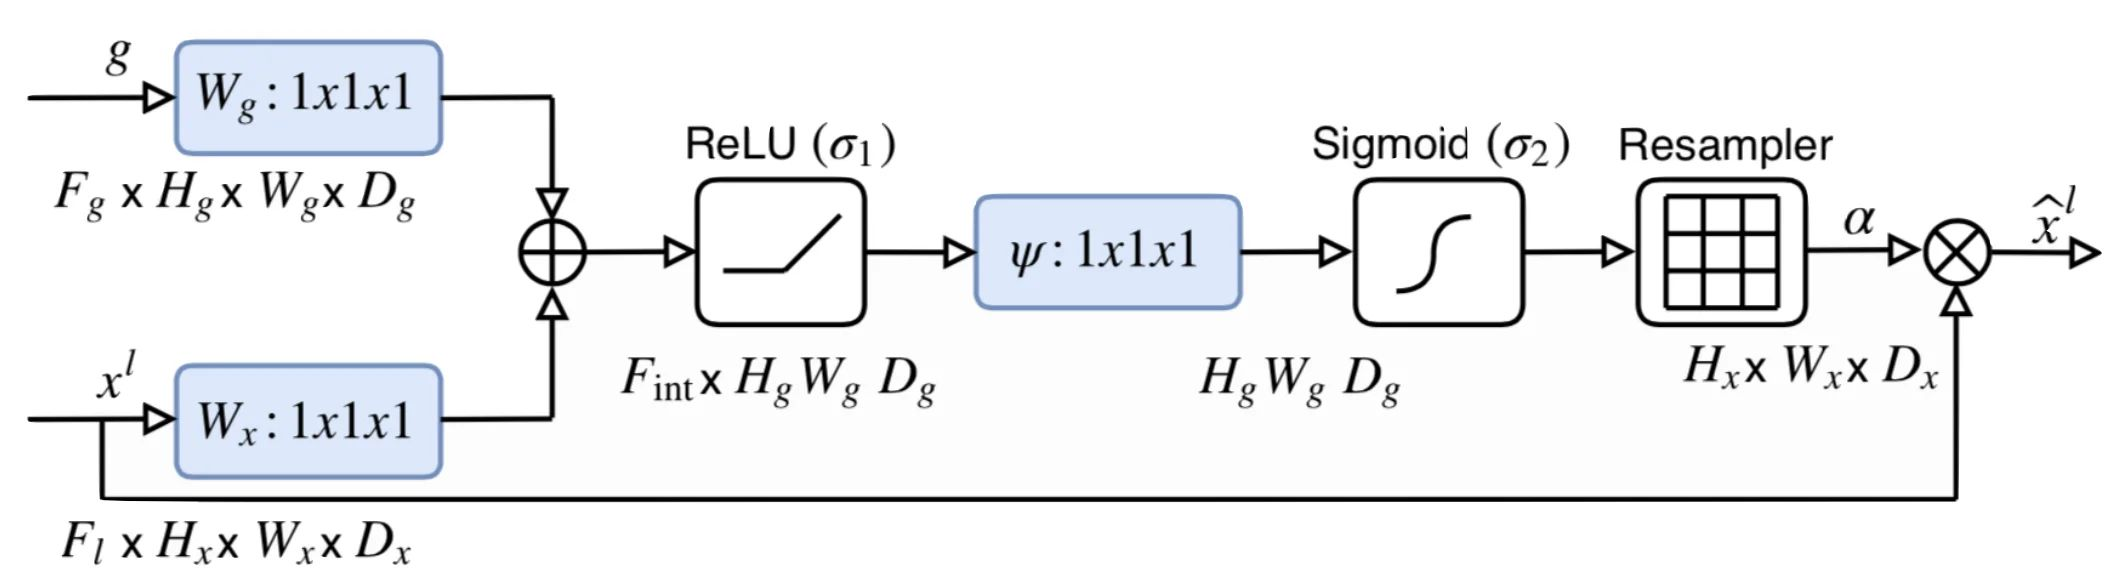

Pada setiap attention gate, terdapat 2 input (x & g). g adalah gating signal, sedangkan x datang dari encoder. Cara kerja attention gate ini akan didefinisikan pada function `attention_block`

Kedua input tersebut (x & g) pada awalnya akan memiliki dimensi yang berbeda karena x berasal dari encoder yang berada 1 step diatas g yang berasal dari decoder (jika x memiliki dimensi 128x128, maka g memiliki dimensi 64x64). Oleh karena itu, x nantinya akan diberikan stride (2, 2) agar dimensinya sama dengan gating signalnya (g). Setelah itu, keduanya akan dijumlahkan sehingga weight-weight yang relevan akan memiliki nilai yang lebih besar, sedangkan weight-weight yang tidak relevan akan memiliki nilai yang lebih kecil (secara rasio)

Setelah itu, akan diimplementasikan activation function ReLU (variabel `act_xg`) yang kemudian akan diberikan activation function sigmoid lagi agar nilainya kembali ke skala 0 - 1

Langkah terakhir adalah melakukan upsampling agar dimensinya kembali seperti semula (sama seperti dimensi x pada awalnya) kemudian multiply dengan x (setiap pixel pada x akan dikalikan dengan nilai weight yang selalu di-update nilainya selama training dilakukan)

In [19]:
def gating_signal(input, size_output):
    # Melakukan resizing terhadap feature map agar dimensinya/sizenya sama dengan feature map pada step diatasnya
    x = layers.Conv2D(size_output, (1, 1), padding='same')(input) # gunakan 1 x 1 convolutional layer
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    # Merubah x agar dimensinya sama dengan gating signal
    theta_x = layers.Conv2D(
        inter_shape, 
        (2, 2), 
        strides = (2, 2), 
        padding = 'same'
    )(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(
        inter_shape,
        (3, 3),
        strides = (shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
        padding = 'same'
    )(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(
        size = (shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2])
    )(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    
    return result_bn

## Definisikan modelWithAttention

Untuk modelWithAttention, arsitekturnya hampir sama persis dengan modelWithoutAttention. Namun, pada model ini kita akan menambahkan `gating_signal` dan `attention_block` pada bagian decoder di setiap step sebelum output layer untuk menerapkan Soft-Attention

In [20]:
def modelWithAttention(input_shape, NUM_CLASSES, dropout_rate):
    num_filter = 128 # number of filters for the first layer
    size_filter = 3 # size of the convolutional filter
    size_upsample = (2, 2) # size of upsampling filters
    
    # input layer
    inputs = layers.Input(input_shape, dtype=tf.float32)

    # Layer-layer di bagian encoder
    
    # step1
    conv_64 = conv_block(inputs, size_filter, num_filter, dropout_rate)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    
    # step2
    conv_32 = conv_block(pool_32, size_filter, 2*num_filter, dropout_rate)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    
    # step3
    conv_16 = conv_block(pool_16, size_filter, 4*num_filter, dropout_rate)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    
    # step4/base sehingga tidak ada max pooling lagi
    conv_8 = conv_block(pool_8, size_filter, 8*num_filter, dropout_rate)

    # Layer-layer di bagian decoder, lakukan soft attention sebelum melakukan upsampling
    
    # step1
    gating_16 = gating_signal(conv_8, 4*num_filter)
    att_16 = attention_block(conv_16, gating_16, 4*num_filter)
    up_16 = layers.UpSampling2D(size=size_upsample, data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=3)
    up_conv_16 = conv_block(up_16, size_filter, 4*num_filter, dropout_rate)
    
    # step2
    gating_32 = gating_signal(up_conv_16, 2*num_filter)
    att_32 = attention_block(conv_32, gating_32, 2*num_filter)
    up_32 = layers.UpSampling2D(size=size_upsample, data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=3)
    up_conv_32 = conv_block(up_32, size_filter, 2*num_filter, dropout_rate)
    
    # step3
    gating_64 = gating_signal(up_conv_32, num_filter)
    att_64 = attention_block(conv_64, gating_64, num_filter)
    up_64 = layers.UpSampling2D(size=size_upsample, data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=3)
    up_conv_64 = conv_block(up_64, size_filter, num_filter, dropout_rate)

    # 1*1 convolutional layers
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_64)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)

    # Model integration
    model = models.Model(inputs, conv_final, name="modelWithAttention")
    
    return model

## Training modelWithAttention

In [21]:
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
num_classes = 1
dropout_p = 0.3
print(input_shape)
att_learning_rate = 0.01

modelWithAttention = modelWithAttention(input_shape, num_classes, dropout_p)
modelWithAttention.compile(
    optimizer = Adam(learning_rate = att_learning_rate),
    loss = BinaryFocalLoss(gamma = 2),
    metrics = ['accuracy', jaccard_coefficient]
)

print(modelWithAttention.summary())

(128, 128, 3)
Model: "modelWithAttention"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 128, 128, 12  3584        ['input_2[0][0]']                
                                8)                                                                
                                                                                                  
 batch_normalization_15 (BatchN  (None, 128, 128, 12  512        ['conv2d_15[0][0]']              
 ormalization)                  8)                                 

 dropout_10 (Dropout)           (None, 16, 16, 1024  0           ['activation_22[0][0]']          
                                )                                                                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 16, 16, 512)  524800      ['dropout_10[0][0]']             
                                                                                                  
 batch_normalization_23 (BatchN  (None, 16, 16, 512)  2048       ['conv2d_23[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_23 (Activation)     (None, 16, 16, 512)  0           ['batch_normalization_23[0][0]'] 
                                                                                                  
 conv2d_25

 up_sampling2d_5 (UpSampling2D)  (None, 64, 64, 1)   0           ['activation_30[0][0]']          
                                                                                                  
 lambda_1 (Lambda)              (None, 64, 64, 256)  0           ['up_sampling2d_5[0][0]']        
                                                                                                  
 multiply_1 (Multiply)          (None, 64, 64, 256)  0           ['lambda_1[0][0]',               
                                                                  'dropout_8[0][0]']              
                                                                                                  
 conv2d_34 (Conv2D)             (None, 64, 64, 256)  65792       ['multiply_1[0][0]']             
                                                                                                  
 up_sampling2d_6 (UpSampling2D)  (None, 64, 64, 512)  0          ['dropout_11[0][0]']             
          

                                8)                                                                
                                                                                                  
 conv2d_43 (Conv2D)             (None, 128, 128, 12  147584      ['activation_36[0][0]']          
                                8)                                                                
                                                                                                  
 batch_normalization_34 (BatchN  (None, 128, 128, 12  512        ['conv2d_43[0][0]']              
 ormalization)                  8)                                                                
                                                                                                  
 activation_37 (Activation)     (None, 128, 128, 12  0           ['batch_normalization_34[0][0]'] 
                                8)                                                                
          

In [22]:
epochs = 3
BATCH_SIZE = 16

att_start_time = datetime.now() 
with_att_history = modelWithAttention.fit(
    X_train, y_train, 
    verbose = 1,
    batch_size = BATCH_SIZE,
    validation_data = (X_val, y_val), 
    shuffle = False,
    epochs = epochs
)
att_stop_time = datetime.now()
execution_time_withatt = att_stop_time-att_start_time
print("With attention execution time is: ", execution_time_withatt)
modelWithAttention.save('with_attention.hdf5')

Epoch 1/3
48/48 [==============================] - 1971s 41s/step - loss: 0.1518 - accuracy: 0.6548 - jaccard_coefficient: 0.2602 - val_loss: 3.5003 - val_accuracy: 0.7824 - val_jaccard_coefficient: 0.2124
Epoch 2/3
48/48 [==============================] - 2252s 47s/step - loss: 0.0835 - accuracy: 0.8755 - jaccard_coefficient: 0.3287 - val_loss: 0.9008 - val_accuracy: 0.8462 - val_jaccard_coefficient: 0.5310
Epoch 3/3
48/48 [==============================] - 2519s 53s/step - loss: 0.0760 - accuracy: 0.8869 - jaccard_coefficient: 0.3453 - val_loss: 0.3575 - val_accuracy: 0.7574 - val_jaccard_coefficient: 0.3805
With attention execution time is:  1:52:24.774454


Model ini setelah di-training dengan 3 epochs berhasil meraih akurasi 88.69% dan validation accuracy 75.74% dengan waktu training 2 jam

# 1c. Evaluasi kedua model

## Display history training kedua model

In [23]:
def display_training_history(history):
    #plot the training and validation accuracy and loss at each epoch
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'y', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    acc = history.history['jaccard_coefficient']
    val_acc = history.history['val_jaccard_coefficient']

    plt.plot(epochs, acc, 'y', label='Training Jacard')
    plt.plot(epochs, val_acc, 'r', label='Validation Jacard')
    plt.title('Training and validation Jacard')
    plt.xlabel('Epochs')
    plt.ylabel('Jacard')
    plt.legend()
    plt.show()

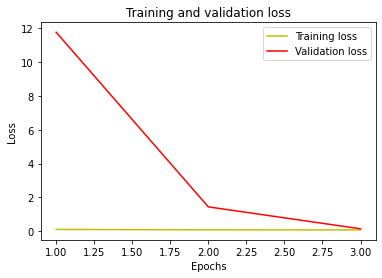

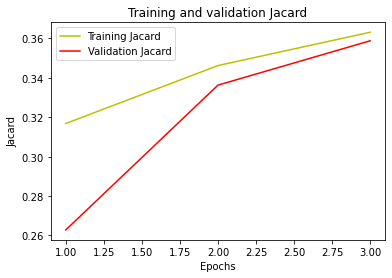

In [24]:
display_training_history(no_att_history)

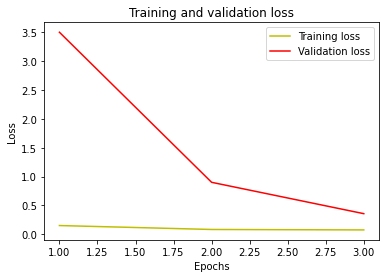

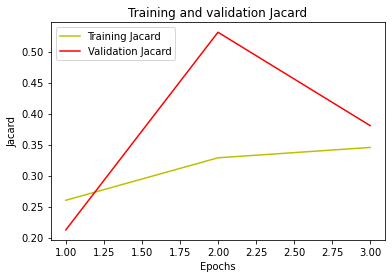

In [25]:
display_training_history(with_att_history)

Dari hasil training kedua model tersebut, tampaknya tidak terjadi overfitting (walaupun hanya di-training dengan 3 epochs)

## Menampilkan 2 gambar random dari test dataset untuk membandingkan kedua model

In [72]:
def show_random_prediction(modelWithAtt, modelWithoutAtt, test_x, test_y, random_index = False):
    index = 190
    if random_index:
        import random
        index = random.randint(0, test_x.shape[0]-1)
        
    test_img = test_x[index]
    ground_truth = test_y[index]

    test_img_input = np.expand_dims(test_img, 0)
    prediction1 = (modelWithoutAtt.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
    prediction2 = (modelWithAtt.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

    plt.figure(figsize=(12, 10))
    plt.subplot(221)
    plt.title('Original Image')
    plt.imshow(test_img, cmap='gray')
    plt.subplot(222)
    plt.title('Ground Truth')
    plt.imshow(ground_truth[:,:,0], cmap='gray')
    plt.subplot(223)
    plt.title('Without Attention Prediction')
    plt.imshow(prediction1, cmap='gray')
    plt.subplot(224)
    plt.title('With Attention Prediction')
    plt.imshow(prediction2, cmap='gray')

    plt.show()

1/1 [==============================] - 1s 798ms/step


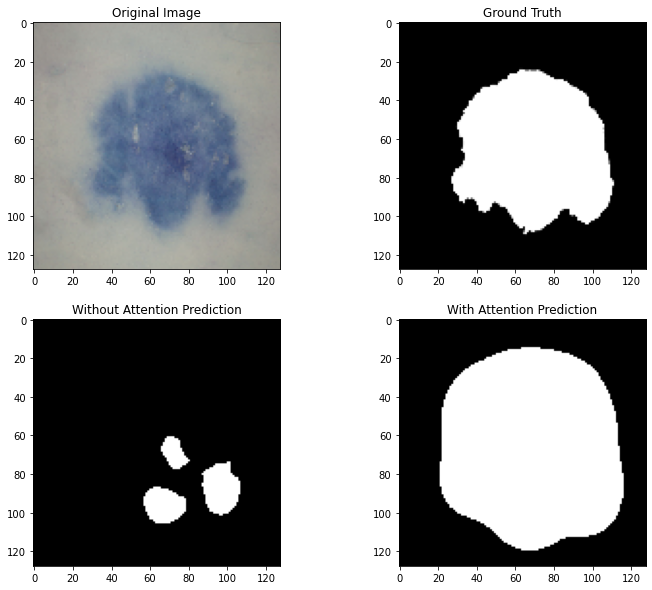

In [73]:
show_random_prediction(modelWithAttention, modelWithoutAttention, test_x, test_y)

1/1 [==============================] - 1s 666ms/step


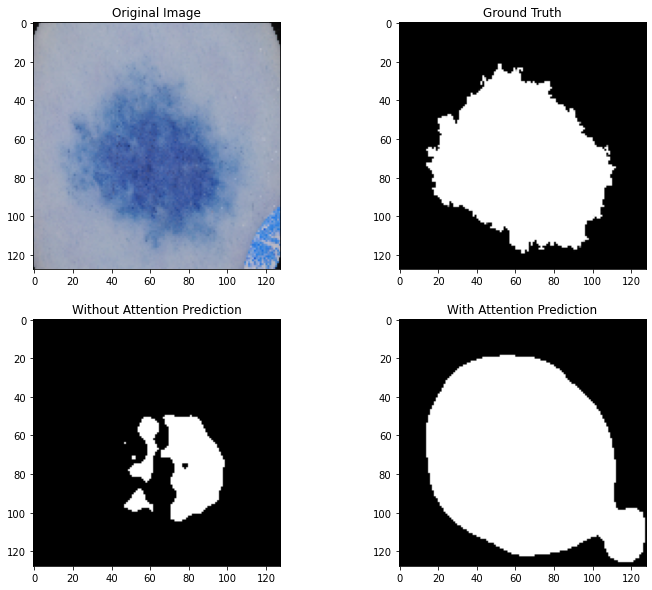

In [74]:
show_random_prediction(modelWithAttention, modelWithoutAttention, test_x, test_y, True)

Dari hasil kedua random image test dataset diatas, tampak bahwa model tanpa soft attention kurang dapat melakukan segmentasi dengan tepat pada gambar dan hanya bisa mendapatkan sedikit bagian dari segmentasi yang seharusnya. Hal ini mengindikasikan bahwa modelWithoutAttention masih kurang bisa melakukan segmentasi dengan sepenuhnya tepat sehingga bisa saja akan ada kasus dimana model ini tidak berhasil mendeteksi skin cancer sama sekali

Sedangkan model dengan soft attention berhasil mendeteksi seluruh skin cancer yang ada pada image dan menghasilkan bentuk mask yang lebih mirip dengan ground truth. Namun, sayangnya model ini juga masih belum sepenuhnya baik karena terlihat bahwa bentuk/shape yang dihasilkan tampak exaggerated/lebih dari seharusnya

## Mengevaluasi kedua model menggunakan 2 metrics

Untuk mengevaluasi kedua model, saya menggunakan 2 metrics, yaitu Jaccard Coefficient (sama dengan IoU Coefficient) dan Binary focal loss

Kedua metric ini sering digunakan untuk memberikan informasi mengenai akurasi prediksi yang dihasilkan oleh model image segmentation

Jaccard coefficient bekerja dengan cara mengukur kemiripan antara mask prediction dengan mask ground truth. Hal tersebut dilakukan dengan menghitung rasio dari intersection dan union (IoU) dari kedua mask tersebut. Hasil dari Jaccard coefficient adalah nilai dari 0 - 1, semakin dekat nilainya ke 1, maka semakin baik/mirip hasil prediksi dengan hasil yang sebenarnya

Binary focal loss sangat berguna untuk mengevaluasi image segmentation karena metric ini merupakan modifikasi dari cross-entropy loss yang akan memberikan weight lebih besar pada pixel yang klasifikasinya salah. Dengan begitu, model akan lebih berfokus untuk memperbaiki diri dalam mengklasifikasi bagian-bagian yang lebih sulit untuk diklasifikasikan sehingga dapat menghindari permasalahan imbalanced dataset (misalnya terdapat banyak image yang mudah untuk di-segmentasi, sementara yang sulit hanya sedikit)

Kedua metric tersebut tidak hanya melihat akurasi dari model, tetapi juga precision dan recall. Mean dari kedua metric ini akan menunjukkan performa dari model secara overall

In [110]:
def evaluate_model(model, test_x, test_y, jaccard_coefficient, IoU_coefficient, binary_focal_loss):
    jaccard_coefs = []
    IoU_coefs = []
    binary_focal_losses = []
    
    for img in range(0, test_x.shape[0]):
        temp_img = test_x[img]
        ground_truth = test_y[img]
        temp_img_input = np.expand_dims(temp_img, 0)
        y_pred = (model.predict(temp_img_input)[0,:,:,0]).astype(float)
        
        jaccard_coef = jaccard_coefficient(ground_truth, y_pred)
        jaccard_coefs.append(jaccard_coef)
        
        iou_coef = IoU_coefficient(ground_truth, y_pred)
        IoU_coefs.append(iou_coef)
        
        binary_focal_loss_value = binary_focal_loss(ground_truth, y_pred)
        binary_focal_losses.append(binary_focal_loss_value)
        
    mean_jaccard_coef = np.mean(jaccard_coefs)
    mean_iou_coef = np.mean(IoU_coefs)
    mean_binary_focal_loss = np.mean(binary_focal_losses)
    
    return mean_jaccard_coef, mean_iou_coef, mean_binary_focal_loss

In [114]:
binary_focal_loss = BinaryFocalLoss(gamma = 2)
mean_jaccard_coef, mean_iou_coef, mean_binary_focal_loss = evaluate_model(modelWithoutAttention, test_x, test_y, jaccard_coefficient, IoU_coefficient, binary_focal_loss)

print("Model Without Attention:")
print("Mean Jaccard coefficient: ", mean_jaccard_coef)
print("Mean IoU coefficient: ", mean_iou_coef)
print("Mean Binary Focal Loss: ", mean_binary_focal_loss)

1/1 [==============================] - 1s 608ms/step


1/1 [==============================] - 1s 636ms/step
Model Without Attention:
Mean Jaccard coefficient:  0.3355662130059432
Mean IoU coefficient:  0.3355662130059432
Mean Binary Focal Loss:  0.34222341771103665


In [113]:
mean_jaccard_coef, mean_iou_coef, mean_binary_focal_loss = evaluate_model(modelWithAttention, test_x, test_y, jaccard_coefficient, IoU_coefficient, binary_focal_loss)

print("Model With Attention:")
print("Mean Jaccard coefficient: ", mean_jaccard_coef)
print("Mean IoU coefficient: ", mean_iou_coef)
print("Mean Binary Focal Loss: ", mean_binary_focal_loss)

1/1 [==============================] - 1s 681ms/step


1/1 [==============================] - 1s 707ms/step
Model With Attention:
Mean Jaccard coefficient:  0.36994626318100715
Mean IoU coefficient:  0.36994626318100715
Mean Binary Focal Loss:  0.9618384801268792


## Evaluasi hasil metrics

Dari hasil kedua metrics tersebut, model dengan Soft-Attention berhasil mendapatkan coefficient yang lebih tinggi, tetapi binary focal lossnya jauh lebih besar. Hasil:

modelWithoutAttention (coefficient = 0.3355, binary focal loss = 0.3422)

modelWithAttention (coefficient = 0.37, binary focal loss = 0.96)

Semakin tinggi Jaccard/IoU coefficient, maka semakin baik performa model tersebut. Semakin rendah nilai binary focal loss, semakin baik juga performa model tersebut.

Namun, dari hasil yang didapatkan, terdapat sedikit 'kontradiksi', modelWithAttention berhasil mendapatkan coefficient yang lebih tinggi yang artinya performanya lebih baik, tetapi binary focal loss yang didapatkan jauh lebih tinggi yang berarti performanya tidak sebaik modelWithoutAttention.

Dari hasil tersebut, menurut saya, sebenarnya modelWithAttention memang memiliki performa yang lebih baik. Hanya saja, modelWithAttention sering sekali melakukan exaggeration terhadap prediksinya sehingga mask yang dihasilkan jauh lebih besar dari ground truth, sedangkan modelWithoutAttention walaupun tidak berhasil memprediksi seluruh bagian dari skin cancer dari setiap image, setidaknya prediksinya tidak melebihi ground truth yang ada. Oleh karena itu, menurut saya hal tersebut yang membuat nilai binary focal loss dari modelWithAttention (yang performanya lebih baik) menjadi sangat besar karena terdapat banyak misclassified pixels akibat exaggeration yang terjadi pada hasil prediksi model ini, padahal sebenarnya performanya dalam melakukan klasifikasi/segmentasi lebih baik

Menurut saya, jika kedua model ini di-train lagi dengan epochs yang jauh lebih tinggi, akan lebih jelas perbedaan kualitas dari kedua model (dimana model dengan Soft-Attention secara teori seharusnya memberikan performa yang lebih baik), terutama ketika melihat 2 random test image yang ditampilkan diatas, tampaknya modelWithAttention sudah bisa mendeteksi keseluruhan bagian dari skin cancer pada setiap image namun butuh beberapa kali training lagi untuk bisa menghasilkan mask yang lebih menyesuaikan bentuk ground truth